##  Importação bibliotecas

In [1]:
import pandas as pd
import utente

import importlib as imp
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Configurações

In [2]:
pd.options.display.max_columns = 100

## Carregamento dos dados

Em máquina Windows ocorre regularmente "Memory Error", provavelmente devido a algumas variáveis que não são limpas ou à cache do servidor do Jupyter. <br>
Um **fix** temporário (se não tivermos o ficheiro local PICKLE) pode ser:
1. Carregar utente.ListaUtentes com forceFetch = True <br>
2. Guardar localmente estrutura objectos em ficheiro PICKLE com output2FileHistoricosTodosUtentes() <br>
3. Fechar e voltar a abrir o Notebook <br>
4. Carregar utente.ListaUtentes com forceFetch = False <br> 
5. Carregar o Pandas Dataframe com pd.DataFrame(listaUtentes.generateDataset()) 

In [3]:
# Opcional: Reload módulo utente
imp.reload(sys.modules['utente']);

In [4]:
# Carregamento estrutura dados (passar parâmetro forceFetch = True para forçar leitura BD >> Demorado!)
listaUtentes = utente.ListaUtentes(forceFetch = False, sqlLimit = 99999999999) # Carrega dados locais a partir de PICKLE

Criar ligação MySQL
Parsing da tabela pedidos_inscritos_longos... (1/7)
Parsing das Anulacoes... (2/7)
Total de 4109 (3%) utentes existentes em sie_31 mas sem equivalencia na pedidos_inscritos_longos:
Parse das Intervenções... (3/7)
Total de 20285 (4%) utentes existentes em sie_35 mas sem equivalencia na pedidos_inscritos_longos:
Parse dos Encaminhamentos... (4/7)
Total de 9761 (7%) utentes existentes em sie_36 mas sem equivalencia na pedidos_inscritos_longos:
Parse dos Apresentações... (5/7)
Total de 4217 (2%) utentes existentes em pd_sie_37 mas sem equivalencia na pedidos_inscritos_longos:
Parse das Convocatórias... (6/7)
Total de 11899 (4%) utentes existentes em pd_sie_38 mas sem equivalencia na pedidos_inscritos_longos:
Parse das Mudanças de Categoria... (7/7)
Total de 7052 (5%) utentes existentes em pd_sie_43 mas sem equivalencia na pedidos_inscritos_longos:
Finalizado com Sucesso!


In [5]:
# Guarda o Pickel localmente
listaUtentes.save()

Saving to ./temp/ListaUtentes.pickle


In [6]:
# Opcional: Output do Histórico de todos Utentes para txt >> Demorado!
listaUtentes.output2FileHistoricosTodosUtentes()

In [7]:
# Criação do dataframe pandas
df = pd.DataFrame(listaUtentes.generateDataset())
listaUtentes = None # Limpa listaUtentes depois de gerar Dataset

In [44]:
# Truncar column names a 64 caracteres e substituir caracteres acentuados
import re
import unidecode
oldColNames = [col for col in df]
newColNames = [ re.sub('[^A-Za-z0-9]+', '',unidecode.unidecode((col)))[:64] for col in df ]

df.rename(columns=dict(zip(oldColNames, newColNames)), inplace=True)

In [45]:
# Guarda Dataframe em tabela MySQL
from sqlalchemy import create_engine
PASSWORD_FILENAME = './password.txt'
with open(PASSWORD_FILENAME) as f: mysqlpass = f.read()
engine = create_engine('mysql+pymysql://helio.b.teixeira:{}@vsrv01.inesctec.pt:3306/datasets'.format(mysqlpass.strip()))
df.to_sql('DatasetModelo', engine, if_exists='replace')

In [47]:
# Colunas do dataframe
[print(col) for col in df];

AreaCurso
AreaFormacao
CategoriaAtrib
CnpAnterior
ConjugeMotivoIndisponibilidade
CursoAnoConclusao
CursoEstabelecimentoEnsinoSup
Data
DataNascimento
DiasDesemprego
Empregado
EstadoCivil
FormacaoProf
HabilitacaoEscolar
Idade
LTU
Nacionalidade
NivelDeficiencia
NrAnulacoes
NrAnulacoesPorMotivoCADUCIDADEDODOCUMENTODEIDENTIFICACAO
NrAnulacoesPorMotivoCOLOCACAOCANDIDATURAEXTERNA
NrAnulacoesPorMotivoCOLOCACAOPORMEIOSPROPRIOSPORCONTADE
NrAnulacoesPorMotivoCOLOCACAOPORMEIOSPROPRIOSPORCONTAPRO
NrAnulacoesPorMotivoCORRECCAOCOLOCACAOFME
NrAnulacoesPorMotivoCORRECCAOREINSCRICAOFME
NrAnulacoesPorMotivoCRIACAODOPROPRIOEMPREGO
NrAnulacoesPorMotivoCUMPRIMENTOSERVICOMILITAR
NrAnulacoesPorMotivoDESISTIU
NrAnulacoesPorMotivoDESISTENCIAOUEXCLUSAODEFORMACAO
NrAnulacoesPorMotivoDESISTENCIAOUEXCLUSAODEMEDIDASDEEMPRE
NrAnulacoesPorMotivoDESISTENCIAOUEXCLUSAODETRABALHOSOCIALM
NrAnulacoesPorMotivoDETENCAOEMESTABELECIMENTOPRISIONAL
NrAnulacoesPorMotivoEMIGRACAOAUSENCIADOPAIS
NrAnulacoesPorMotivoFALECIMENTO
NrAnul

## Limpeza das variáveis

Substituição de `None` por 0's e correcção do Types

In [12]:
# DataNascimento
df['DataNascimento'].fillna(value=np.nan, inplace = True)
df['DataNascimento'] = pd.to_datetime(df['DataNascimento'])

In [7]:
# Substitui por 0 todos Nones nas colunas que 
# começam por NrAnulacoesPorMotivo ou NrApresentacoesComResultado
filter_col = [col for col in df if col.startswith('NrAnulacoesPorMotivo') 
                                   or col.startswith('NrApresentacoesComResultado')]

for col in filter_col:
    df[col].fillna(value=0, inplace = True);
    df[col]=df[col].astype('int');

In [8]:
# Empregado?
df['Empregado'] = df['Empregado'].astype('category')

## Novas Features

### Idade

In [15]:
df['IdadeCalculada'] = (df['Data']-df['DataNascimento']).astype('timedelta64[Y]')
# Não tem grande utilidade...Apagar

***

## Análise Exploratória Univariada

### LTU

In [10]:
df['LTU'] = df['LTU'].astype('category');
df['LTU'].describe()

count     123701
unique         3
top            ?
freq       75608
Name: LTU, dtype: object

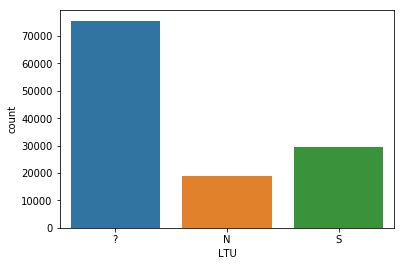

In [11]:
sns.countplot(x='LTU', data=df);

### DiasDesemprego

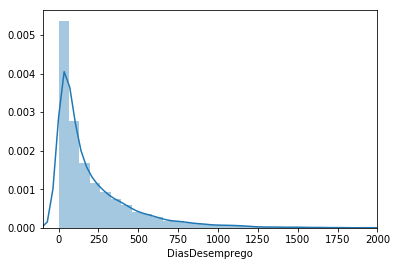

In [13]:
df_empregados = df[(df['Empregado']=='S')] 
# Só faz sentido mostrar aqueles que acabaram por ficar empregados
sns.distplot(df_empregados['DiasDesemprego'])
plt.xlim(-100, 2000);

In [14]:
#skewness e kurtosis
print("Skewness: %f" % df['DiasDesemprego'].skew())
print("Kurtosis: %f" % df['DiasDesemprego'].kurt())

Skewness: 34.710146
Kurtosis: 5270.179240


### Idade

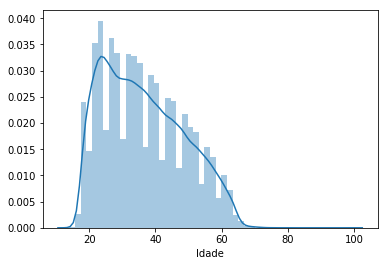

In [53]:
sns.distplot(df['Idade'].dropna())

***

## Análise Exploratória Multivariada

### DiasDesemprego-Sexo

Comparação das populações do sexo Masculino e Feminino em relação dos dias de desemprego.<br>
**Nota:** Deve-se filtar apenas as observações que resultaram em emprego pois só nesses casos sabemos ao certo quantos foram os dias que estiveram desempegados

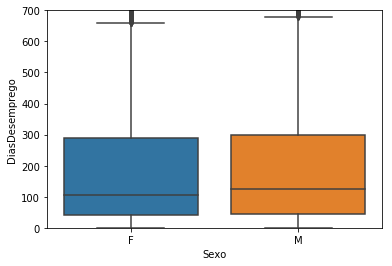

In [17]:
sns.boxplot(x='Sexo', y='DiasDesemprego', data=df_empregados)
plt.ylim(0, 700);

Olhando para a Mediana, aparentemente os utentes do sexo masculino ficam mais tempo desempregados...

In [18]:
print("Mediana 'DiasDesemprego' (Sexo M): {:.0f} dias".format(df_empregados[df.Sexo == 'M']['DiasDesemprego'].median()))
print("Mediana 'DiasDesemprego' (Sexo F): {:.0f} dias".format(df_empregados[df.Sexo == 'F']['DiasDesemprego'].median()))

Mediana 'DiasDesemprego' (Sexo M): 125 dias
Mediana 'DiasDesemprego' (Sexo F): 106 dias


<div class="alert alert-block alert-info"> 
- __[Shortcuts](https://www.cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/)__
- __[Markdown](http://datascience.ibm.com/blog/markdown-for-jupyter-notebooks-cheatsheet/)__